# Sales Prediction for Rossmann Stores

* Preprocessing steps 
* RandomForest model 
* Neural network model 

# Data Preperation for RandomForests and Neural Nets
* Summary of Steps:
    * Import Statements
    * Load data
    * Define Categorical and Continuous Variables

## Import Statements

In [4]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [5]:
from fastai.imports import *
from fastai.structured import *
from fastai.column_data import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
import altair as alt
from altair import Chart, X, Y, Axis, SortField
alt.renderers.enable('notebook')
from pandas import Timestamp
#import ggplot
np.set_printoptions(threshold=50, edgeitems=20)
from pdpbox import pdp
from plotnine import *
import feather
import pandas as pd
#import pdvega


## Load Feather Data

In [6]:
# File path
path_processed = 'data/processed/'
!ls {path_processed}

joined      joined_test models      tmp


In [7]:
#Load feature engineered dataset using feather format
joined = feather.read_dataframe(f'{path_processed}joined')
joined_test = feather.read_dataframe(f'{path_processed}joined_test')
joined.columns

Index(['index', 'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open',
       'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'State', 'file', 'Max_TemperatureC',
       'Mean_TemperatureC', 'Min_TemperatureC', 'Dew_PointC', 'MeanDew_PointC',
       'Min_DewpointC', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity',
       'Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
       'Min_Sea_Level_PressurehPa', 'Max_VisibilityKm', 'Mean_VisibilityKm',
       'Min_VisibilitykM', 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h',
       'Max_Gust_SpeedKm_h', 'Precipitationmm', 'CloudCover', 'Events',
       'WindDirDegrees', 'StateName', 'Year', 'Month', 'Week', 'Day',
       'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year

## Define Categorical & Continuous Variables
* The dataset contains a mix of continuous and categorical variables.   
* It is useful to explicitly identify and define categorical variables as pandas categories to:
    * reduce the tree computation cost for RandomForests.
    * create RandomForest model with one hot encoding.
    * create embedding matrices for neural nets.

In [8]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']
n = len(joined); n

844338

In [9]:
dep = 'Sales'
joined = joined[cat_vars+contin_vars+[dep, 'Date']].copy()

In [10]:
joined_test[dep] = 0
joined_test = joined_test[cat_vars+contin_vars+[dep, 'Date', 'Id']].copy()

### Convert Categorical Variables to Pandas Categories.
Loop through the list of categoricals and convert them to Pandas categories. 

In [11]:
for v in cat_vars: 
    joined[v] = joined[v].astype('category').cat.as_ordered()

The same category mapping applied on training data is applied to the test set.  
Eg: If saturday is a 6 in the training set, apply_cats() ensures that same encoding is applied to the test set also.

In [12]:
apply_cats(joined_test, joined)

### Convert Continuous Variables to Float
* Loop through the list of continuous variables and set them as float (Neural Nets/PyTorch requirement). 

In [13]:
for v in contin_vars:
    joined[v] = joined[v].fillna(0).astype('float32')
    joined_test[v] = joined_test[v].fillna(0).astype('float32')

In [14]:
# Set date as the index
joined_samp = joined.set_index("Date")

## Preprocessing for RandomForests
* Replace categories with their numeric codes
* Handle missing values
* Assign the dependent variable as a separate variable

**Missing Values:**
* Replace missing values for categories with 0.  
(Missing categorical variables are assigned as -1 by default. Hence all categorical variables are bumped up by 1, so the missing categorical variables are assigned 0, and the numeric codes for other categorical variables start from 1.)
* Replace missing values for continuous variables with their medians.

## Function proc_df( )
**Parameters**
* joined_samp: Independent variables
* Sales: Dependent variable

In [15]:
df, y, nas = proc_df(joined_samp, 'Sales')
y = np.log(y)

In [16]:
joined_test = joined_test.set_index("Date")

In [17]:
df.isnull().sum().sort_values(ascending=False).head(7)

SchoolHoliday               0
Promo                       0
Events                      0
Week                        0
State                       0
Promo2SinceYear             0
CompetitionOpenSinceYear    0
dtype: int64

## Define Training Data and Validation Set

In [18]:
def split_vals(a,n): 
    return a[:n], a[n:]

In [19]:
n_valid = 10000
n_trn = len(df)-n_valid
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)


In [20]:
raw_train, raw_valid = split_vals(joined_samp, n_trn)

# Error definition : Root Mean Square Percent Error (RMSPE)
* Root Mean Square Percent Error (RMSPE): Evaluation metric suggested by Kaggle in the Rossmann Competition.
* RMSPE means we are penalized based on the ratio of the predicted value and the actual value.
* Calculating the Root Mean Squared Error of the log(data) will give us the Root Mean Squared Percent Error.

In [21]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())
def print_score(m):
    res = [exp_rmspe(m.predict(X_train), y_train), exp_rmspe(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [22]:
**set_rf_samples() :**  * Randomly samples 50000 rows from the dataset each time.

SyntaxError: invalid syntax (<ipython-input-22-1c9790da04bb>, line 1)

# RandomForest Model 

### Function RandomForestRegressor ( )
**Parameters**

**n_estimators :** Number of trees.

**min_sample_leaf :** Depth of the tree.

**max_features :** Randomly sample columns at each split.
Rationale:
* The less correlated your trees are with each other, the better. 
* If one column was more predictive than all other columns then every single tree will be split based on that column. But there might be some interaction of variables where that interaction is more important than the individual column. So if every tree always splits on the same thing the first time, we will not get much variation in those trees.
* Using Max features - we can carryout column sampling - i.e for every individual binary split, we choose from a different subset of columns. 0.5 means we randomly choose a half of them.

**n_jobs=-1**
* Random forests are trivially parallelizable.
* n_jobs=-1 tells the random forest regressor to create a separate job/process for each CPU core.

**Out-of-bag (OOB) Score :**
* OOB score indcates the model error on the rows not included in the training set.
* Its an additional metric to check if the model is overfitting.  

## Single Tree

In [23]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.4567976214492103, 0.5097539347455193, 0.22338971012780795, 0.177919812374201]


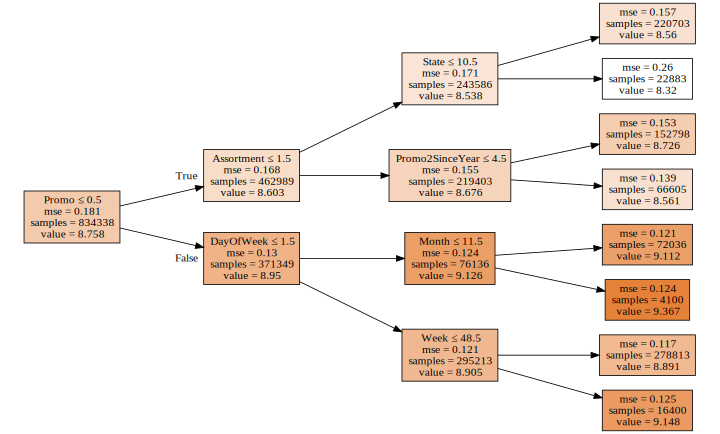

In [24]:
draw_tree(m.estimators_[0], df, precision=3)

In [25]:
#set_rf_samples(50000)

### Function fit ( )
** Parameters**  
**X_train:** Independent Variables  
**y_train:** Dependent Variable

In [26]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=2, max_features=0.99, n_jobs=-1,oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.99, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [27]:
print_score(m)

[0.0666155588589929, 0.13635516205966372, 0.98243678545286, 0.9234500779736768, 0.9258115397614479]


## Feature Importance
The feature importance indicates the most important columns.  
Working:  
**Step 1:** Train a random forest model (m).  
**Step 2:** Randomly shuffle each column and use the model (m) to predict the dependent variable. Now that the coloumn is randomly shuffled, the relationship between the dependent variable and the independent variable is lost, resulting in a poor predictive accuracy. This difference enables us to calculate the feature importance.

### Function rf_feat_importance ( )
**Parameters**  
**m :** RandomForest model  
**df :** dataframe  

In [28]:
fi = rf_feat_importance(m, df); fi[:10]

,cols,imp
22,CompetitionDistance,0.189276
34,Promo,0.166405
0,Store,0.148714
13,State,0.083534
11,CompetitionOpenSinceYear,0.070380
1,DayOfWeek,0.060835
12,Promo2SinceYear,0.040392
8,StoreType,0.039268
9,Assortment,0.026026
14,Week,0.020798


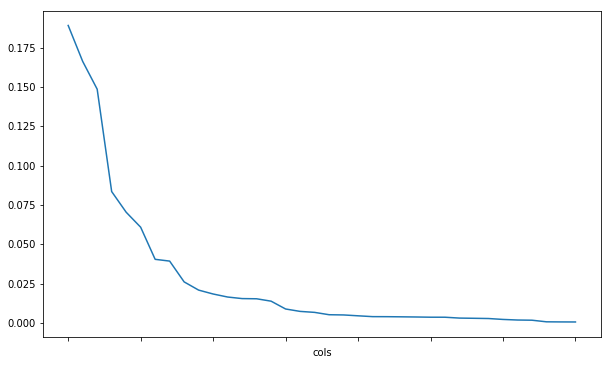

In [29]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);


In [30]:
def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(16,10), legend=False)

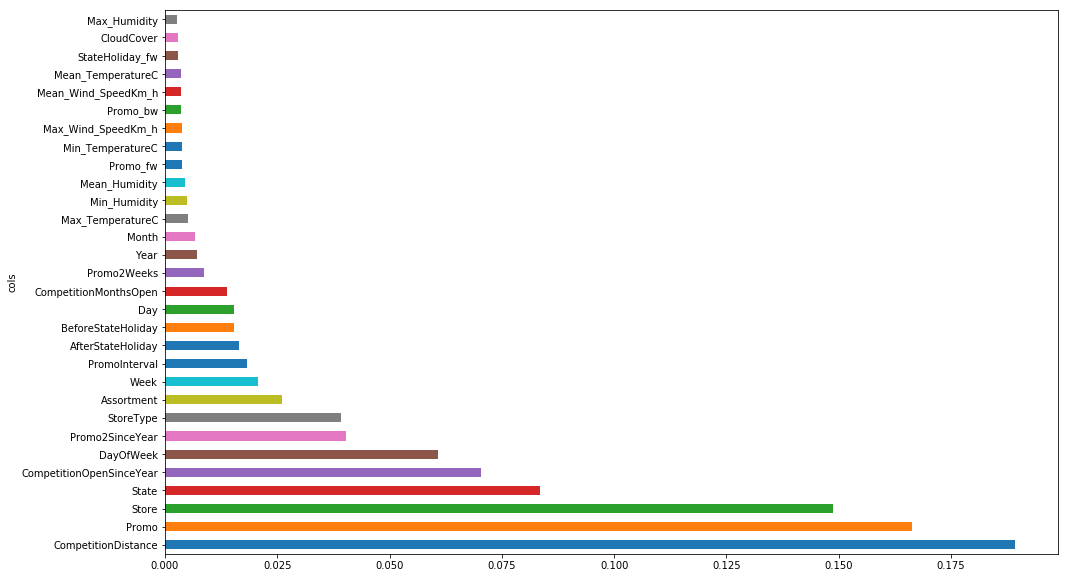

In [31]:
plot_fi(fi[:30]);

### Discussion
* _CompetitionDistance and Promotions turn out to be the most important features._

## Fine Tune Model Based on Feature Importance

**Remove the colums whose feature importance is less than or equal to 0.01 and check if there is any any impact on model accuracy and feature importance.**

In [32]:
# Remove columns whose feature importance is less than 0.01
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

19

In [33]:
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [34]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.99,n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.10165283990750787, 0.1351407648529399, 0.9718782894101309, 0.9262774152464296, 0.9273370605111451]


### Discussion
* _The R-Square accuarcy is very similar to the oriignal model, but the model is a bit simpler now._
* _

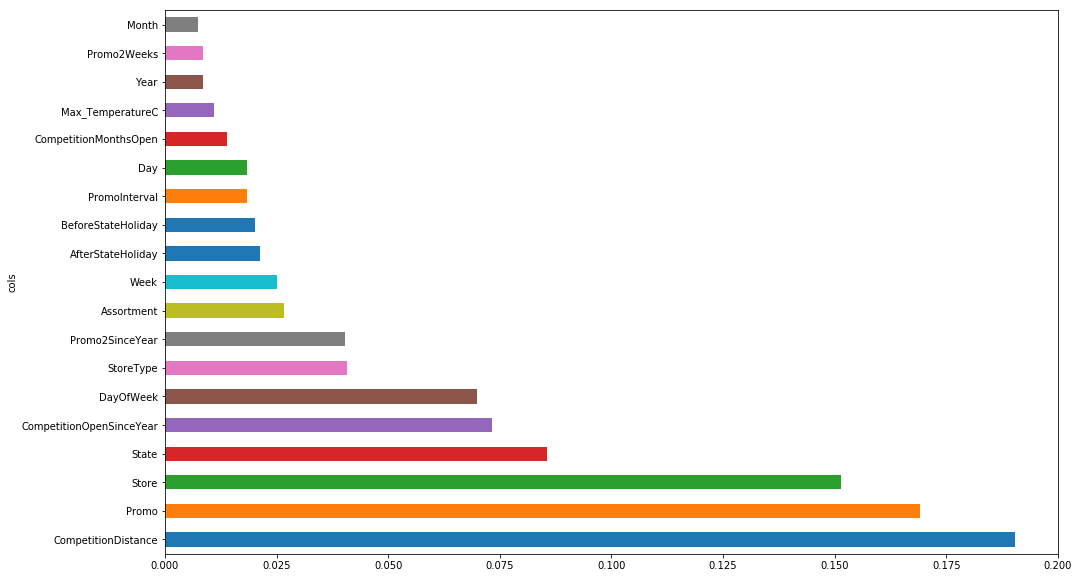

In [35]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

### Discussion
* _The feature importance remains the same after eliminating less important variables._


## One-hot encoding

* Convert coulmuns with cardinality less than 7 into seperate binary columns.  
* proc_df's optional *max_n_cat* argument will turn categorical variables into new columns.
* Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

For example, the column **StoreType** which has 4 categories:

* a
* b
* c
* d

gets turned into 6 new columns:

* StoreType_a
* StoreType_b
* StoreType_c
* StoreType_d

and the column **StoreType** gets removed.



In [36]:
df_trn2, y_trn, nas = proc_df(joined_samp, 'Sales',max_n_cat=7)
y_trn = np.log(y_trn)
#df_trn2.isnull().sum().sort_values(ascending=False).head(7)

In [37]:
#df_trn2.columns.str.endswith('_nan', na=False)
#df_trn2[df_trn2.columns[pd.Series(df_trn2.columns).str.endswith('_nan')]].describe()

for c in df_trn2.columns:
    if c.endswith('_nan'):
        if c in df_trn2.columns: df_trn2.drop(c, inplace=True, axis=1)

In [38]:
df_trn2.columns

Index(['Store', 'Month', 'Day', 'CompetitionMonthsOpen', 'Promo2Weeks',
       'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 'Week',
       'Events', 'SchoolHoliday_fw', 'SchoolHoliday_bw', 'CompetitionDistance',
       'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h',
       'Mean_Wind_SpeedKm_h', 'CloudCover', 'AfterStateHoliday',
       'BeforeStateHoliday', 'Promo', 'SchoolHoliday', 'DayOfWeek_1.0',
       'DayOfWeek_2.0', 'DayOfWeek_3.0', 'DayOfWeek_4.0', 'DayOfWeek_5.0',
       'DayOfWeek_6.0', 'DayOfWeek_7.0', 'Year_2013.0', 'Year_2014.0',
       'Year_2015.0', 'StateHoliday_False', 'StateHoliday_True', 'StoreType_a',
       'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_a',
       'Assortment_b', 'Assortment_c', 'PromoInterval_Feb,May,Aug,Nov',
       'PromoInterval_Jan,Apr,Jul,Oct', 'PromoInterval_Mar,Jun,Sept,Dec',
       'Promo_fw_0.0', 'Promo_fw_1.0', 'Promo_fw_2.0',

In [39]:
X_train, X_valid = split_vals(df_trn2, n_trn)
m_ohe = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.99, n_jobs=-1, oob_score=True)
m_ohe.fit(X_train, y_train)
print_score(m_ohe)


[0.08959343704430954, 0.14362989655392405, 0.974427841756548, 0.9160944145944484, 0.9230144800346556]


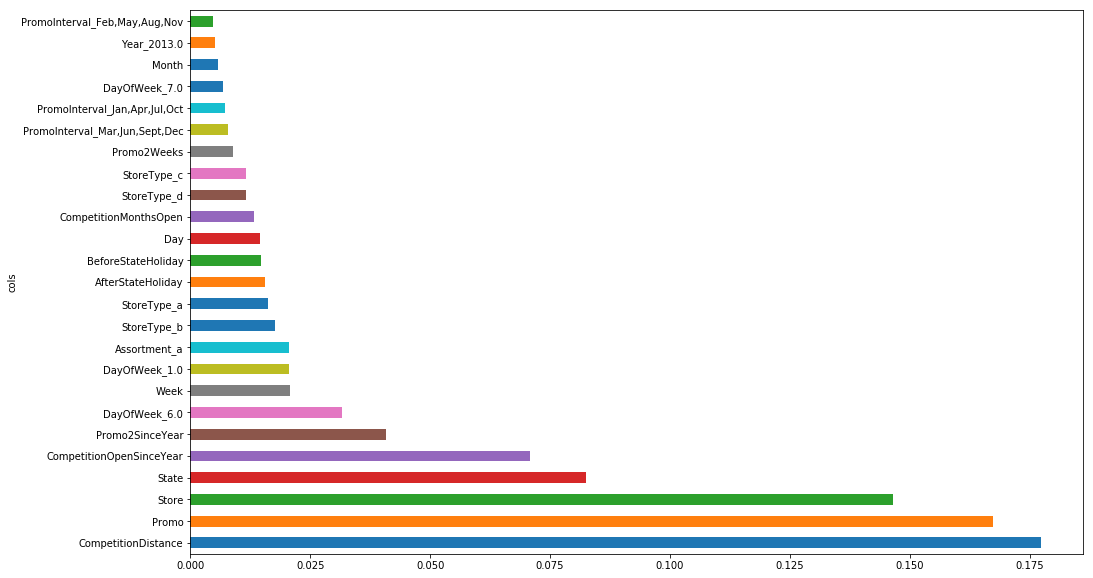

In [40]:
fi = rf_feat_importance(m_ohe, df_trn2)
plot_fi(fi[:25]);

## Data exploration Based on Feature Importance
### Competition Distance
The feature importance function indiactes the competition distance to be the most important variable.  
Lets understand this variable better.


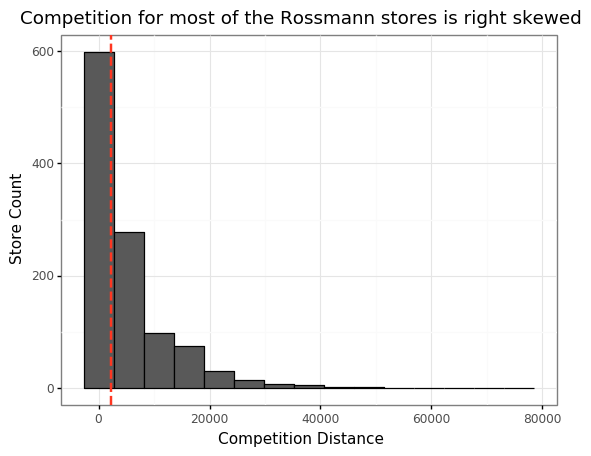

<ggplot: (7618040966)>

In [41]:
df_tmp= joined_samp.copy()
df_tmp = df_tmp.groupby('Store', as_index = False).agg({'Assortment': 'min','StoreType':'min',
                                                    'CompetitionDistance': 'max','CompetitionOpenSinceYear': 'max',
                                                    'CompetitionMonthsOpen':'max','Sales': 'mean'})

(ggplot(data=df_tmp,mapping=aes(x='CompetitionDistance')) 
+ geom_histogram(bins =15, colour="black")
+ labs(
        title ='Competition for most of the Rossmann stores is right skewed',
        x = 'Competition Distance',
        y = 'Store Count',
    ) 
 + geom_vline(xintercept = 2320, size = 1, colour = "#FF3721",linetype = "dashed")
+ theme_bw()
)

In [42]:
df_tmp.CompetitionDistance.median()

2320.0

In [43]:
df_tmp[df_tmp.CompetitionDistance <= df_tmp.CompetitionDistance.median()].Store.count()


559

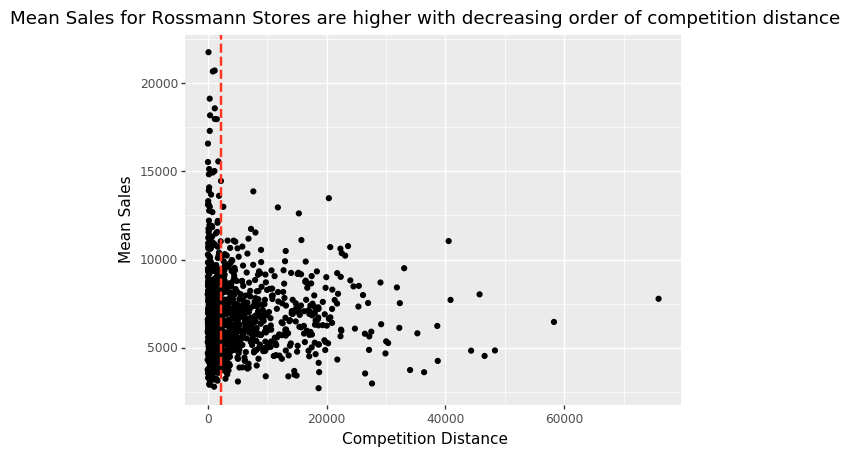

<ggplot: (7618038031)>

In [44]:
(ggplot(data=df_tmp,mapping=aes(x='CompetitionDistance', y = 'Sales')) 
+ geom_point()
+ labs(
        title ='Mean Sales for Rossmann Stores are higher with decreasing order of competition distance',
        x = 'Competition Distance',
        y = 'Mean Sales',
    ) 
+ geom_vline(xintercept = 2320, size = 1, colour = "#FF3721",linetype = "dashed")
)

### Partial Dependece Plots

In [45]:
x = get_sample(X_train[X_train.CompetitionDistance <=3000], 1000)

In [46]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m_ohe, x, x.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c61209208>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c60f767f0>})

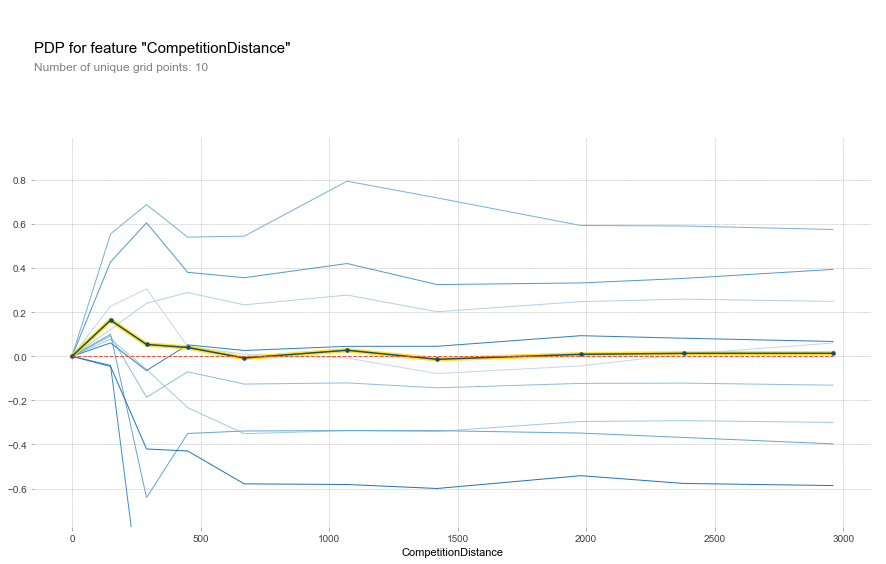

In [47]:
plot_pdp('CompetitionDistance', clusters=10)

## Discussion:
* The Competition Distance < 500 impacts the sales of the store.


### Promotions

In [49]:
#df_promo = joined_samp.groupby('Promo',as_index = False).agg({'Sales': 'mean'})
df_promo_store = joined_samp.groupby(['Store','Promo'],as_index = False).agg({'CompetitionDistance': 'max','StoreType':'min','Assortment': 'min','Sales': 'mean'})
df_promo_store.head()

#df_tmp= joined_samp.copy()
#df_tmp = df_tmp.groupby('Store', as_index = False).agg({'Assortment': 'min','StoreType':'min',
#                                                    'CompetitionDistance': 'max','CompetitionOpenSinceYear': 'max',
#                                                    'CompetitionMonthsOpen':'max','Sales': 'mean'})



,Store,Promo,CompetitionDistance,StoreType,Assortment,Sales
0,1,0.0,1270.0,c,a,4319.756381
1,1,1.0,1270.0,c,a,5300.111429
2,2,0.0,570.0,a,a,3864.288372
3,2,1.0,570.0,a,a,6277.440678
4,3,0.0,14130.0,a,a,5382.613054


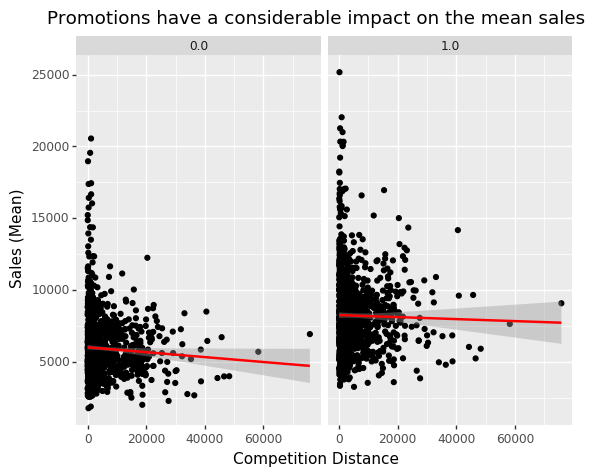

<ggplot: (7617802423)>

In [50]:
(
ggplot(df_promo_store, aes(x = 'CompetitionDistance', y ='Sales'))
 + geom_point()
 + geom_smooth(
        aes(x = 'CompetitionDistance',
            y = 'Sales'),
           colour='red')
 + labs(
        title ='Promotions have a considerable impact on the mean sales',
        x = 'Competition Distance',
        y = 'Sales (Mean)',
    )
+
facet_wrap('Promo')
)

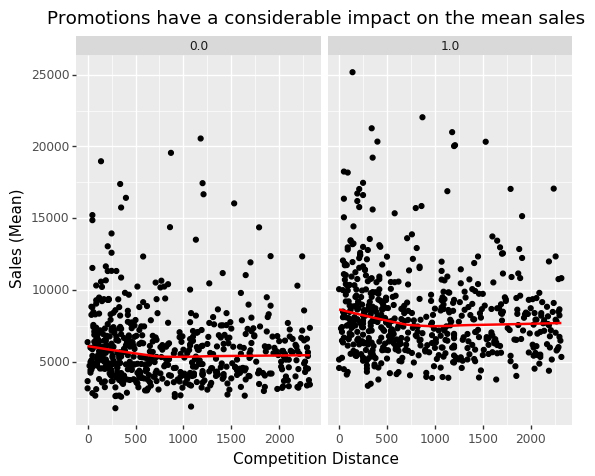

<ggplot: (-9223372029236813831)>

In [51]:
(
ggplot(df_promo_store[df_promo_store.CompetitionDistance <=2320], aes(x = 'CompetitionDistance', 
                                                       y ='Sales'))
 + geom_point()
 + geom_smooth(
        aes(x = 'CompetitionDistance',
            y = 'Sales'),
           colour='red')
 + labs(
        title ='Promotions have a considerable impact on the mean sales',
        x = 'Competition Distance',
        y = 'Sales (Mean)',
    )
+
facet_wrap('Promo')
)

## Summary
* RandomForest model gave us a decent accuracy for Sales prediction.
* The accuracy obtained would put us in the top 2000 of the public leaderboard.
* More importantly it helped us identify the important variables and help us understand the data better.
* However if we need to obtain better preduction results we need to use Neural networs with hidden layers to better capture the interactions.

# Neural networks

This code an implementation of the third place winners of the Rossman Kaggle competition as detailed in Guo/Berkhahn's Entity Embeddings of Categorical Variables (https://arxiv.org/abs/1604.06737) by Jermy Howard in the fastai course.


### To Run on a Random Subset of the Dataset
Train the neural net on a small sample 
* to ensure everything is working fine, 
* to determine the optimum hyperparameters and architectures.

In [60]:
idxs = get_cv_idxs(n, val_pct=150000/n)
joined_samp = joined.iloc[idxs].set_index("Date")
samp_size = len(joined_samp); samp_size

150000

### To Run on the Complete Dataset

In [78]:
samp_size = n
joined_samp = joined.set_index("Date"); samp_size

844338

In [61]:
joined_samp.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Mean_Humidity,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-16,257,2,2015,6,16,False,24,0,a,a,...,60.0,35.0,18.0,8.0,6.0,22.0,0.0,1.0,0.0,5934
2013-10-30,4,3,2013,10,30,False,24,0,c,c,...,72.0,48.0,29.0,16.0,2.0,27.0,-56.0,0.0,0.0,7800


## Preprocessing for Neural Networks

### Function proc_df ( ):
* **joined_samp:** Independent variables
* **Sales:** Dependent variable
* **do_scale = True:** Normalizes all columns with mean = 0, and SD = 1
* **mapper :** contains the mean and SD used for normalization of continuous varaibales in the training set. It is important to apply the same mapping used for the training set on to the test set.

proc_df () ensures both the test and train set have the same:
* Missing value replacements
* Normalization parameters

In [62]:
df, y, nas, mapper = proc_df(joined_samp, 'Sales', do_scale=True)
y = np.log(y)

In [63]:
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True, skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)

In [64]:
df.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-16,257,2,3,6,16,1,25,1,1,1,...,-0.033719,-1.053689,-0.756430,-0.519502,-0.651394,0.413263,-0.525077,1.128737,1.115768,-0.489079
2013-10-30,4,3,1,10,30,1,25,1,3,3,...,-0.809377,-0.147082,-0.095984,0.704530,0.700532,-1.400579,-0.363976,-0.591499,-0.896244,-0.489079


**Note:**
* The year variable is replaced by 3, and categorical variables are replaced by the pandas categories code in above output snippet.
* Important step for creating embedding matrices later.

## Define Training Data and Validation Set
* In time series data, cross-validation is not random. 
* Holdout data is generally the most recent data. Hence we take 25% of the rows sorted by date as the initial validation set. (https://www.fast.ai/2017/11/13/validation-sets/)

In [65]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
#val_idx = list(range(train_size, len(df)))

112500

## Validation Set
We need to predict the next two weeks of sales in the test set, therefore we create a validation set which is the last two weeks of our training set.

In [66]:
val_idx = np.flatnonzero(
    (df.index<=datetime.datetime(2014,9,17)) & (df.index>=datetime.datetime(2014,8,1)))

### To Run on Complete Dataset for the Final Model
* We retrain the final model on the whole dataset including the validation set.
* Fastai -assumes we always have a validations set.
* Hence define the first row as a validation set as a workaround.

In [79]:
val_idx=[0]

## Create Model Data Object  
ColumnarModelData represents a training set, validation set and an optional test set of a standard structured data.
* path_processed: Specifies the location to store the model files.
* val_idx: List of indices of the rows of the validation set
* df: Data frame
* y: Dependent Variable
* cat_flds: List of columns to be treated as categorical variables.

In [67]:
md = ColumnarModelData.from_data_frame(path_processed, val_idx, df, y.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

## Embeddings

In [68]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [69]:
# Sttore: 1116 -> indicates the number of rows in the embedding matrix
cat_sz

[('Store', 1116),
 ('DayOfWeek', 8),
 ('Year', 4),
 ('Month', 13),
 ('Day', 32),
 ('StateHoliday', 3),
 ('CompetitionMonthsOpen', 26),
 ('Promo2Weeks', 27),
 ('StoreType', 5),
 ('Assortment', 4),
 ('PromoInterval', 4),
 ('CompetitionOpenSinceYear', 24),
 ('Promo2SinceYear', 9),
 ('State', 13),
 ('Week', 53),
 ('Events', 22),
 ('Promo_fw', 7),
 ('Promo_bw', 7),
 ('StateHoliday_fw', 4),
 ('StateHoliday_bw', 4),
 ('SchoolHoliday_fw', 9),
 ('SchoolHoliday_bw', 9)]

### Discussion:
* _Some columns have more categories or levels than others._
    * _Eg: Store has over 1000 levels._

## Embedding Matrix
* Embedding matrices have to shown to perform better than one-hot encodings.
 * Embeddings - by having higher dimensionality vector rather than just a single number, gives the deep learning network a chance to learn rich representations.

### Embedding Matrix - Definition
* Cardinality of the variables is used to define the size of the embedding matrix. 
* Each level will be assosiated with a vector based on the length as per the rules defined below:
    * Rule of thumb 1 - Dimensionality of the embeddings are set as half of the discrete value the category has, up to maximum of 50.
    * Rule of thumb 2 - Even if there were no missing values set an extra one aside for unknown.

In [70]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
# Returns a list of tuples

In [71]:
emb_szs

[(1116, 50),
 (8, 4),
 (4, 2),
 (13, 7),
 (32, 16),
 (3, 2),
 (26, 13),
 (27, 14),
 (5, 3),
 (4, 2),
 (4, 2),
 (24, 12),
 (9, 5),
 (13, 7),
 (53, 27),
 (22, 11),
 (7, 4),
 (7, 4),
 (4, 2),
 (4, 2),
 (9, 5),
 (9, 5)]

In [72]:
max_log_y = np.max(y)
y_range = (0, max_log_y*1.2)

#### Function get_learner ( )
**Parameters**
* emb_szs: Embedding size
* len(df.columns)-len(cat_vars): Number of continuous variables in the data frame.
* 1: Number of outputs (Output of the last linear layer - We need to predict one number i.e Sales)
* 0.04: Dropout of the embedding matrix.
* [1000,500]: Activations in the linear layers.
* [0.001,0.01]: Dropouts to use in subsequent layers

**Dropouts**
* Output of each linear layer is going to be a rank 1 tensor.
* Dropout is going to remove some of the activations.

In [73]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
m.summary()

OrderedDict([('Embedding-1',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 50]),
                           ('trainable', True),
                           ('nb_params', 55800)])),
             ('Embedding-2',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 4]),
                           ('trainable', True),
                           ('nb_params', 32)])),
             ('Embedding-3',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 2]),
                           ('trainable', True),
                           ('nb_params', 8)])),
             ('Embedding-4',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 7]),
                           ('trainable', True),
                           ('nb_params', 91)])),
             ('Embedding-5',
              OrderedDict([('input_shape', [-1])

In [74]:
lr = 1e-3
m.lr_find()

 63%|██████▎   | 711/1120 [00:12<00:06, 59.42it/s, loss=0.159] 

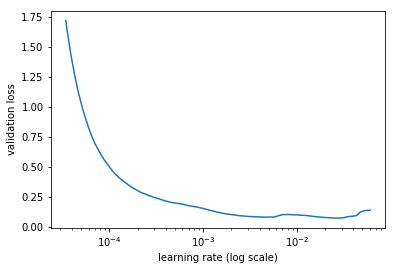

In [75]:
m.sched.plot(100)

In [76]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

### Function fit ( )
**Parameters**
* lr : Learning Rate
* 2 : Number of Cycles
* metrics: Print the results of this function at the end of each cycle

In [77]:
m.fit(lr, 2, metrics=[exp_rmspe], cycle_len=4)

epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.037096   0.030388   0.179321  
    1      0.020377   0.034185   0.162426                       
    2      0.020185   0.018004   0.131996                       
    3      0.013975   0.022116   0.136012                       
    4      0.018074   0.017798   0.126142                       
    5      0.013234   0.020693   0.131354                       
    6      0.011524   0.018708   0.125148                       
    7      0.009965   0.019052   0.125549                        


[array([0.01905]), 0.1255488586076484]

### Complete Dataset

In [80]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

## Hyperparameter Tuning

In [81]:
m.fit(lr, 3, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.025572   0.027111   0.149342  
    1      0.019368   0.028548   0.150992                       
    2      0.017404   0.050042   0.193518                       


[array([0.05004]), 0.19351823221810305]

In [82]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.012941   0.016259   0.117742  
    1      0.011761   0.016148   0.116976                       
    2      0.010539   0.015615   0.115455                       


[array([0.01561]), 0.11545468890520136]

### Test Set

In [83]:
m.save('val0')

In [84]:
m.load('val0')

In [85]:
x,y=m.predict_with_targs()

In [86]:
exp_rmspe(x,y)

0.1177177868657602

### Discussion
* This result would put us in the top 100 of the Kaggle Private Leader Board.

In [87]:
pred_test=m.predict(True)

In [88]:
pred_test = np.exp(pred_test)

In [89]:
joined_test['Sales']=pred_test

In [91]:
csv_fn=f'{path_processed}tmp/sub.csv'

In [92]:
joined_test[['Id','Sales']].to_csv(csv_fn, index=False)

# Summary
* Neural Networks gives really good accuracy beased on Root Mean Square Percent Error.
* It better captures the complex time series interction through the use of enrtity embedding matrices.
* RandomForests was useful for initial data exploration and understand the results of the neural nets.